In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn.metrics
import time

import faiss  # KNN testing - python 3.5 only?
from scipy.stats import mode

import matplotlib.pyplot as plt 

# SVM:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import GradientBoostingClassifier

In [34]:


os_dir = os.path.abspath('')
os_dir_data = os.path.join(os_dir, r"data/original/")

test_csv_path = os_dir_data + "1000_test.csv"
train_csv_path = os_dir_data + "1000_train.csv"

header_list = ["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26"]

test_df = pd.read_csv(test_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header
train_df = pd.read_csv(train_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header


In [35]:
print(test_df.shape)
print(train_df.shape)

####### scale data

df_columns = list(test_df.columns)

df_columns_features = df_columns
df_columns_label = df_columns[0]
df_columns_features.pop(0)


print(df_columns_features)
print(type(df_columns_features))

scaler = StandardScaler()
test_df[df_columns_features] = scaler.fit_transform(test_df[df_columns_features])
train_df[df_columns_features] = scaler.fit_transform(train_df[df_columns_features])

####### end scale data

(3500000, 28)
(7000000, 28)
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']
<class 'list'>


In [69]:
n_samples = 3500000  # 400000

####### Separate the label from the normal dataframe

test_subsample_df = test_df.sample(n=n_samples, random_state=1)
train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
#######

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier

SVM specific code below:

In [70]:
start = time.time()

use_RF = "base"

n_estimators_arr = [100]
min_leaf_arr = [10]

report_roc_auc_best = 0
best_est = 0
best_minleaf = 0
for estimators in n_estimators_arr: 
    for min_leaf in min_leaf_arr:
        if use_RF == "base":
            clf = RandomForestClassifier(random_state=1, min_samples_leaf=min_leaf, n_jobs=-1, criterion="entropy")  # min_samples_leaf=20, 
        # elif use_RF == "bag":
        #     pass
        elif use_RF == "boost":
            clf = XGBRFClassifier(n_estimators=100,n_jobs=-1, random_state=1, booster="dart", learning_rate=0.1)
        elif use_RF == "boost2":
            clf = GradientBoostingClassifier(random_state=1, min_samples_leaf=min_leaf, n_estimators=estimators)

        
        # Fitting 
        clf.fit(train_subsample_df, train_subsample_label_arr)





        end = time.time()
        # print("Random Forest Time", end - start)
        report_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf.predict_proba(test_subsample_df)[:,1])
        print(f"{estimators} | {min_leaf} | {report_roc_auc}")

        if report_roc_auc > report_roc_auc_best:
            best_est = estimators
            best_minleaf = min_leaf
            report_roc_auc_best = report_roc_auc

print("Bests:")
print(f"Estimators: {best_est} | Min LEaf: {best_minleaf} | AUC: {report_roc_auc_best}")

100 | 10 | 0.9716184321132397
Bests:
Estimators: 100 | Min LEaf: 10 | AUC: 0.9716184321132397


[0.9707610205319522, 0.9708080958921895, 0.9707931848382139, 0.9707570312954236, 0.9707128864675745]
Plot of AUC


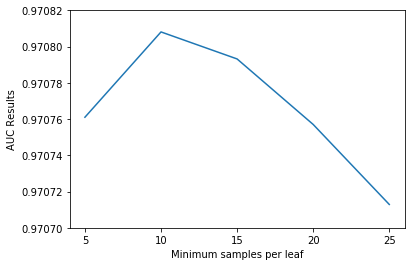

Plot of time to run for GPU Faiss KNN


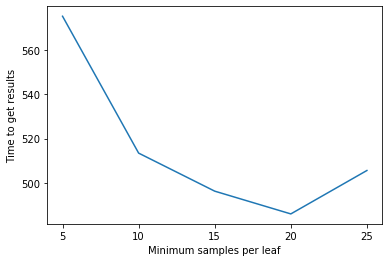

In [62]:
n_estimators = 10
start = time.time()

use_RF = "boost2"

# n_samples_arr = [1000,2000,3000]
# n_samples_arr = [100000,500000,1000000,1500000,2000000,2500000, 3000000,3500000]
n_estimators_arr = [100]
min_leaf_arr = [5,10,15,20,25]

n_samples_arr= np.array(n_samples_arr)

# time_arr_boosting100 = []
# auc_score_arr_boosting100 = []

# time_arr_noBoost = [25.411887645721436, 216.0146520137787, 469.08976650238037, 749.5976288318634, 958.1802494525909, 1270.5282804965973, 1557.2228844165802, 1877.4026145935059]
# auc_score_arr_noBoost = [0.9674172637113612, 0.9695612532556381, 0.970361860815065, 0.9705676559380876, 0.9708065178314438, 0.9709629535969241, 0.9710877882887448, 0.9711819776739613]

time_arr_noBoost = [575.1591980457306, 513.4826021194458, 496.33774852752686, 486.08240962028503, 505.64995288848877]
auc_score_arr_noBoost = [0.9707610205319522, 0.9708080958921895, 0.9707931848382139, 0.9707570312954236, 0.9707128864675745]

# report_roc_auc_best = 0
# best_est = 0
# best_minleaf = 0
# for estimators in n_estimators_arr: 
#     for min_leaf in min_leaf_arr:
#         time_start_noboost = time.time()

#         clf = RandomForestClassifier(random_state=1, min_samples_leaf=min_leaf, n_estimators=estimators, n_jobs=-1, criterion="entropy") 
        
#         # Fitting 
#         clf.fit(train_subsample_df, train_subsample_label_arr)

#         time_end_noboost = time.time()
#         # print("Random Forest Time", end - start)
#         report_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf.predict_proba(test_subsample_df)[:,1])
#         print(f"{estimators} | {min_leaf} | {report_roc_auc}")

#         if report_roc_auc > report_roc_auc_best:
#             best_est = estimators
#             best_minleaf = min_leaf
#             report_roc_auc_best = report_roc_auc

#         auc_score_arr_noBoost.append(report_roc_auc)
#         time_arr_noBoost.append(time_end_noboost - time_start_noboost)

#         #### debug
#         print(f"No Boost Time arr: {time_arr_noBoost}")
#         print(f"No Boost AUC: {auc_score_arr_noBoost}")

#         # time_start_boost = time.time()

#         # clf = GradientBoostingClassifier(random_state=1, min_samples_leaf=min_leaf, n_estimators=estimators)

#         # # Fitting 
#         # clf.fit(train_subsample_df, train_subsample_label_arr)

#         # time_end_boost = time.time()
#         # # print("Random Forest Time", end - start)
#         # report_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf.predict_proba(test_subsample_df)[:,1])
#         # print(f"{estimators} | {min_leaf} | {report_roc_auc}")

#         # if report_roc_auc > report_roc_auc_best:
#         #     best_est = estimators
#         #     best_minleaf = min_leaf
#         #     report_roc_auc_best = report_roc_auc

#         # auc_score_arr_boosting100.append(report_roc_auc)
#         # time_arr_boosting100.append(time_end_boost - time_start_boost)

#         # #### debug
#         # print(f"Boost Time arr: {time_arr_boosting100}")
#         # print(f"Boost AUC: {auc_score_arr_boosting100}")

# # print("Bests:")
# # print(f"Estimators: {best_est} | Min LEaf: {best_minleaf} | AUC: {report_roc_auc_best}")

print(auc_score_arr_noBoost)

print("Plot of AUC")
fig, ax = plt.subplots()
ax.plot(min_leaf_arr, auc_score_arr_noBoost)
# ax.plot(n_samples_arr*2, auc_score_arr_boosting100)
plt.xlabel('Minimum samples per leaf')
plt.ylabel('AUC Results')
# ax.legend(["No Boost RF", "Boosting RF"])
ax.set_xticks(min_leaf_arr)
ax.set_ylim([.97070,.97082])
plt.show()

fig, ax = plt.subplots()
print("Plot of time to run for GPU Faiss KNN")
ax.set_xticks(n_samples_arr)
ax.plot(min_leaf_arr, time_arr_noBoost)
# ax.plot(n_samples_arr*2, time_arr_boosting100)
plt.xlabel('Minimum samples per leaf')
plt.ylabel('Time to get results')
# ax.legend(["No Boost RF", "Boosting RF"])
ax.set_xticks(min_leaf_arr)
plt.show()

In [67]:
sample_weights_arr = np.where(train_subsample_label_arr == 1, 1, 1)
clf = RandomForestClassifier(random_state=1, min_samples_leaf=10, n_estimators=100, n_jobs=-1, criterion="entropy") 

max_val = 0
best_l0 = 0
best_l1 = 0
for label_0_weight in np.linspace(.1,2,10):
    for label_1_weight in np.linspace(.1,2,10):
        if label_1_weight == label_0_weight:
            continue
        sample_weights_arr = np.where(train_subsample_label_arr == 1, label_1_weight, label_0_weight)
        clf.fit(train_subsample_df, train_subsample_label_arr, sample_weights_arr)

        probs = clf.predict_proba(test_subsample_df)[:,1]
        report_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=probs)

        if report_roc_auc > max_val:
            max_val = report_roc_auc
            best_l0 = label_0_weight
            best_l1 = label_1_weight

        print(f"Label 0: {label_0_weight}| Label 1: {label_1_weight} | AUC: {report_roc_auc}")
print(f"Best L0: {best_l0}, Best L1: {best_l1}, AUC: {max_val}")

Label 0: 0.1| Label 1: 0.3111111111111111 | AUC: 0.9681377167326305
Label 0: 0.1| Label 1: 0.5222222222222223 | AUC: 0.9681000566701549
Label 0: 0.1| Label 1: 0.7333333333333333 | AUC: 0.9679747125965569
Label 0: 0.1| Label 1: 0.9444444444444444 | AUC: 0.9679460327966702
Label 0: 0.1| Label 1: 1.1555555555555557 | AUC: 0.9678789499291294
Label 0: 0.1| Label 1: 1.3666666666666667 | AUC: 0.9678994556720464
Label 0: 0.1| Label 1: 1.577777777777778 | AUC: 0.967882671755069
Label 0: 0.1| Label 1: 1.788888888888889 | AUC: 0.9678511071350762
Label 0: 0.1| Label 1: 2.0 | AUC: 0.9679408969608756
Label 0: 0.3111111111111111| Label 1: 0.1 | AUC: 0.9682428138651155
Label 0: 0.3111111111111111| Label 1: 0.5222222222222223 | AUC: 0.9681909823038702
Label 0: 0.3111111111111111| Label 1: 0.7333333333333333 | AUC: 0.9682181330931005
Label 0: 0.3111111111111111| Label 1: 0.9444444444444444 | AUC: 0.9681745917896348
Label 0: 0.3111111111111111| Label 1: 1.1555555555555557 | AUC: 0.9680557871616142
Label 